# Analysis and Hypothesis Testing for "Splatoon 2" and "Splatoon 3"

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import timedelta
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
import math

#### In this notebook, I will answer the question "Is my splatrate higher for matches that I win?" using data about my Splatoon gameplay that I entered manually from the Official Nintendo SplatNet app. 

In [15]:
splatoon = pd.read_csv('New_Splatoon2.csv')
splatoon.columns

Index(['Mode', 'Notes', 'Overall XP', 'Rank (XP)', 'Kills (w/o assist)',
       'Kills (w/ assist)', 'Deaths', 'Specials', 'Team Splashdowns',
       'Opponent Splashdowns', 'Team Hensei', 'Opponent Hensei',
       'Team Member 1 Kills (w/o assist)', 'Team Member 2 Kills (w/o assist)',
       'Team Member 3 Kills (w/o assist)',
       'Team Member Avg Kills (w/o assist)', 'Team Member 1 Kills (w/ assist)',
       'Team Member 2 Kills (w/ assist)', 'Team Member 3 Kills (w/ assist)',
       'Team Member Avg Kills (w/ assist)', 'Opponent 1 Kills (w/o assist)',
       'Opponent 2 Kills (w/o assist)', 'Opponent 3 Kills (w/o assist)',
       'Opponent 4 Kills (w/o assist)', 'Average Opponent Kills (w/o assist)',
       'Opponent 1 Kills (w/ assist)', 'Opponent 2 Kills (w/ assist)',
       'Opponent 3 Kills (w/ assist)', 'Opponent 4 Kills (w/ assist)',
       'Opponent Avg Kills (w/ assist)', 'Team Member 1 Deaths',
       'Team Member 2 Deaths', 'Team Member 3 Deaths',
       'Team Member Av

In [16]:
#Win Rate
100*(len(splatoon[splatoon["Won?"]==True])/splatoon.shape[0])

55.319148936170215

In [17]:
splatoon2 = splatoon.loc[:, ["Kills (w/ assist)", "Deaths", "Team Member 1 Kills (w/ assist)","Team Member 2 Kills (w/ assist)", "Team Member 3 Kills (w/ assist)", "Team Member Avg Kills (w/ assist)", "Team Count", "Opponent Count", "Won?"]]
#Calculate kill rate for wins vs kill rate for losses
splatoon2.sort_values("Won?", ascending=False).head(5)
wins = splatoon2.copy()[splatoon2["Won?"]==True]
losses = splatoon2.copy()[splatoon2["Won?"]==False]
win_killrate = wins["Kills (w/ assist)"] / wins["Deaths"]
loss_killrate = losses["Kills (w/ assist)"] / losses["Deaths"]

splatoon2["my_win_killrate"] = win_killrate
splatoon2["my_lose_killrate"] = loss_killrate

splatoon2.head(5)

,Kills (w/ assist),Deaths,Team Member 1 Kills (w/ assist),Team Member 2 Kills (w/ assist),Team Member 3 Kills (w/ assist),Team Member Avg Kills (w/ assist),Team Count,Opponent Count,Won?,my_win_killrate,my_lose_killrate
0,9,10,5,8,13,8.666667,39,66,False,NaN,0.9
1,12,7,6,16,6,9.333333,93,0,True,1.714286,NaN
2,7,8,10,15,5,10.000000,99,13,True,0.875000,NaN
3,14,7,13,8,8,9.666667,94,28,True,2.000000,NaN
4,15,7,8,9,8,8.333333,55,45,True,2.142857,NaN


**Using the bootstrap method for A/B testing**

Question: Could the difference in splatrates for games where I won and lost be due to chance?

Null hypothesis: The distributions of the win splatrates are the same as the distributions of the loss splatrates, and they are different in the sample due to chance.

Alternate hypothesis: Win splatrates in games of splatoon are higher than loss splatrates.

Test statistic: abs(median of wins - median of losses). If the distributions are the same, the test statistic should be 0.

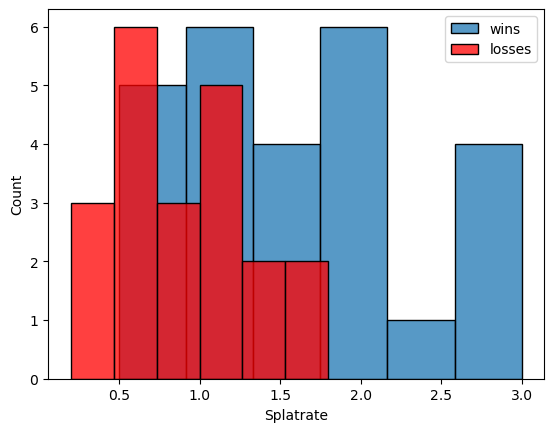

In [18]:
splatoon2[["my_win_killrate", "my_lose_killrate"]]
ax = sns.histplot(data=splatoon2, x="my_win_killrate")
ax = sns.histplot(data=splatoon2, x="my_lose_killrate", color="r")
ax.set_xlabel("Splatrate")
ax.legend(labels=["wins","losses"])

A/B testing by shuffling the labels

In [19]:
splatoon2["my_splatrate"] = splatoon2["Kills (w/ assist)"] / splatoon2["Deaths"]
a_b_krs = splatoon2[["my_splatrate", "Won?"]]
a_b_krs.head(5)

,my_splatrate,Won?
0,0.900000,False
1,1.714286,True
2,0.875000,True
3,2.000000,True
4,2.142857,True


In [21]:
#Find the observed difference
#grouped = a_b_krs.groupby("Won?").agg(np.average).sort_values("Won?", ascending=False)
#grouped["my_kr"].values[0] - grouped["my_kr"].values[1]
observed_difference = np.median(a_b_krs[a_b_krs["Won?"]==True]["my_splatrate"].values) - np.median(a_b_krs[a_b_krs["Won?"]==False]["my_splatrate"].values)
observed_difference

0.6607142857142856

In [25]:
def one_stat(tbl, label):
    """Calculates absolute difference between win and loss"""
    grouped = shuffled_tbl.groupby("Won2").agg(np.median).reset_index()
    return abs(grouped["my_splatrate"].values[0] - grouped["my_splatrate"].values[1])

all_diffs = np.array([])

for i in np.arange(1000):
    conditions = a_b_krs.sample(n=len(a_b_krs), replace=False)["Won?"].values
    shuffled_tbl = a_b_krs.drop(columns=["Won?"]) #.insert(1, column="Won2", value = conditions)
    shuffled_tbl["Won2"] = conditions
    all_diffs = np.append(all_diffs, one_stat(shuffled_tbl, "Won2"))

all_diffs[:5]

array([0.16666667, 0.05555556, 0.5       , 0.3125    , 0.375     ])

<Axes: xlabel='All Differences', ylabel='Count'>

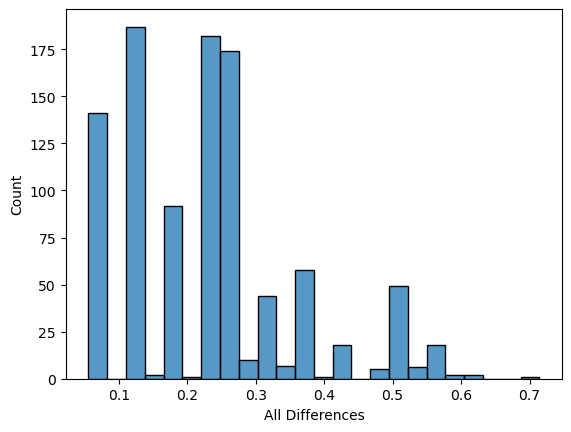

In [26]:
new = pd.DataFrame()
new["All Differences"] = all_diffs
sns.histplot(data=new, x="All Differences")

In [27]:
p_value = np.count_nonzero(all_diffs>=observed_difference)/1000
p_value

0.001

Since the p_value is 0.001: reject the null hypothesis; therefore, win killrates in games of splatoon are higher than loss killrates.

##### NOTE: #####
This hypothesis test is not that useful since there isn't enough data (there are only 100 rows) since I am manually entering data from the SplatNet apps. As of now, there doesn't seem to be a way to set up a scraper for an official Nintendo app, but if I can automate data mining and add to the csv every time I play a match, I would get more data (and therefore more accurate results).

## Misc: EDA -- is there an association between how many splats we have and how many points we score?

In [28]:
splatoon3 = pd.read_csv("Splatoon3.csv")
splatoon3.head()

,Mode,Time,Kills (w/assist),Deaths,Team Kill 1,Team Kill 2,Team Kill 3,Team Count,Enemy Count,Won?,Unnamed: 10
0,Tower Control,2:30,4,3,12,12,3,100,0,True,NaN
1,Tower Control,5:17,11,12,14,7,7,78,98,False,NaN
2,Tower Control,5:23,13,8,14,14,7,88,31,True,NaN
3,Tower Control,5:24,7,9,16,13,7,80,92,False,NaN
4,Tower Control,2:44,8,2,4,4,4,100,0,True,NaN


In [29]:
#Standardize time to seconds
from datetime import timedelta

def convert_to_seconds(x):
    minutes, seconds = map(float, x.split(":"))
    td = timedelta(minutes=minutes, seconds=seconds)
    return td.total_seconds()

splatoon3["Seconds"] = splatoon3["Time"].apply(convert_to_seconds)
splatoon3.head(5)

,Mode,Time,Kills (w/assist),Deaths,Team Kill 1,Team Kill 2,Team Kill 3,Team Count,Enemy Count,Won?,Unnamed: 10,Seconds
0,Tower Control,2:30,4,3,12,12,3,100,0,True,NaN,150.0
1,Tower Control,5:17,11,12,14,7,7,78,98,False,NaN,317.0
2,Tower Control,5:23,13,8,14,14,7,88,31,True,NaN,323.0
3,Tower Control,5:24,7,9,16,13,7,80,92,False,NaN,324.0
4,Tower Control,2:44,8,2,4,4,4,100,0,True,NaN,164.0


In [30]:
#Find mean of teammates' kills
splatoon3["Team Kill Mean"] = splatoon3.iloc[:, 4:7].sum(axis=1)/3
#Determine if the match was a close match by finding the difference between teams' counts
splatoon3["Count Difference"] = abs(splatoon3["Team Count "]-splatoon3["Enemy Count"])
#Find my kill rate
splatoon3["Kill Rate"] = splatoon3["Kills (w/assist)"]/splatoon3["Deaths"]
splatoon3.head(5)

,Mode,Time,Kills (w/assist),Deaths,Team Kill 1,Team Kill 2,Team Kill 3,Team Count,Enemy Count,Won?,Unnamed: 10,Seconds,Team Kill Mean,Count Difference,Kill Rate
0,Tower Control,2:30,4,3,12,12,3,100,0,True,NaN,150.0,9.000000,100,1.333333
1,Tower Control,5:17,11,12,14,7,7,78,98,False,NaN,317.0,9.333333,20,0.916667
2,Tower Control,5:23,13,8,14,14,7,88,31,True,NaN,323.0,11.666667,57,1.625000
3,Tower Control,5:24,7,9,16,13,7,80,92,False,NaN,324.0,12.000000,12,0.777778
4,Tower Control,2:44,8,2,4,4,4,100,0,True,NaN,164.0,4.000000,100,4.000000


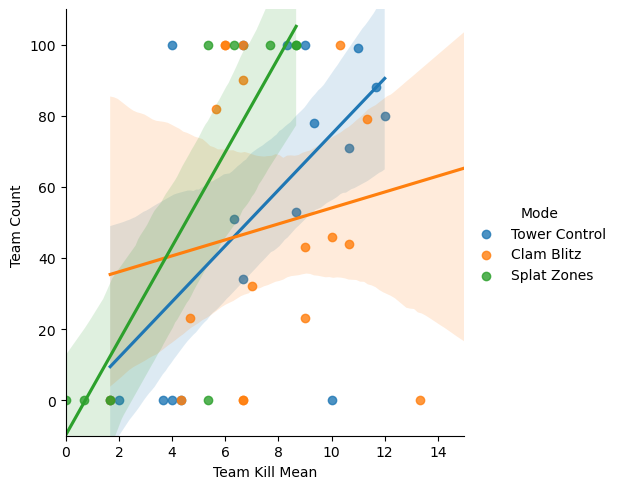

In [31]:
scatter = sns.lmplot(data=splatoon3, x="Team Kill Mean", y="Team Count ", hue="Mode")
scatter.set(xlim=(0, 15))
scatter.set(ylim=(-10, 110))

There seems to be a positive correlation between all modes. However, there are not enough points (not enough data) to determine if there actually is an association between the two.